<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/HTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Time Series

# Install

In [1]:
!pip install scikit-hts[all]
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 20.4 MB/s 
     |████████████████████████████████| 91 kB 9.4 MB/s 
     |████████████████████████████████| 59 kB 3.6 MB/s 
     |████████████████████████████████| 1.4 MB 39.7 MB/s 
     |████████████████████████████████| 675 kB 37.7 MB/s 
     |████████████████████████████████| 925 kB 38.9 MB/s 
  Created wheel for h3: filename=h3-3.4.3-cp37-cp37m-linux_x86_64.whl size=81880 sha256=ed5f605dd4955322c99add52c3b20f423dc2e869dd2323a67c12a634b5ebdbe6
  Stored in directory: /root/.cache/pip/wheels/06/d7/c4/4bdd2790d18c61490459a8baf00bc1f95114ed68c399a45617
Successfully built h3
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
   

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error

import hts.functions
from hts import HTSRegressor

In [3]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

# Parameters

In [113]:
START = '2016-01-01'
SPLIT = '2017-08-01'

STORES = ['1', '2', '3']
FAMILIES = ['PRODUCE', 'BEVERAGES', 'HOME CARE']
MODELS = ['prophet', 'holt_winters', 'sarimax']
REVISION_METHODS = {
    'BU': 'Bottom Up',
    'NONE': 'Baseline',
    'PHA': 'Proportions',
    'OLS': 'Optimal'
}

# Data

## Kaggle

In [14]:
!pwd

/content


In [12]:
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!rm kaggle.json

In [13]:
!kaggle competitions download -c store-sales-time-series-forecasting

 42% 9.00M/21.4M [00:00<00:00, 46.2MB/s]
100% 21.4M/21.4M [00:00<00:00, 88.2MB/s]


In [15]:
!unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


## Read Data

In [121]:
train_df = pd.read_csv('train.csv')
train_df['store_nbr'] = train_df.store_nbr.astype(str)
train_df['date'] = pd.to_datetime(train_df.date)

In [122]:
train_df = train_df[(train_df.family.isin(FAMILIES)) & (train_df.store_nbr.isin(STORES))].copy()
test_df  = train_df[train_df.date >= SPLIT].copy()
train_df = train_df[(train_df.date >= START) & (train_df.date < SPLIT)].copy()

In [123]:
train_df

,id,date,store_nbr,family,sales,onpromotion
1945947,1945947,2016-01-01,1,BEVERAGES,0.000,0
1945962,1945962,2016-01-01,1,HOME CARE,0.000,0
1945974,1945974,2016-01-01,1,PRODUCE,0.000,0
1946310,1946310,2016-01-01,2,BEVERAGES,0.000,0
1946325,1946325,2016-01-01,2,HOME CARE,0.000,0
...,...,...,...,...,...,...
2972757,2972757,2017-07-31,2,HOME CARE,293.000,9
2972769,2972769,2017-07-31,2,PRODUCE,2284.938,13
2973105,2973105,2017-07-31,3,BEVERAGES,7954.000,29
2973120,2973120,2017-07-31,3,HOME CARE,590.000,9


## Info

In [124]:
# Number of Stores
len(train_df.store_nbr.unique())

3

In [125]:
# Product Family
len(train_df.family.unique())

3

In [126]:
# Dates
train_df.date.min(), train_df.date.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2017-07-31 00:00:00'))

In [127]:
# Dates
test_df.date.min(), test_df.date.max()

(Timestamp('2017-08-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

# Hierarchical

## Coherence
* Forecast time series individually
* Make them consistent within a hierarchy

## Stores & Families

In [128]:
LEVELS = ['store_nbr', 'family']
HIERARCHY = [['store_nbr'], ['family']]
DATE_COL = 'date'
VALUE_COL = 'sales'

In [129]:
train_df

,id,date,store_nbr,family,sales,onpromotion
1945947,1945947,2016-01-01,1,BEVERAGES,0.000,0
1945962,1945962,2016-01-01,1,HOME CARE,0.000,0
1945974,1945974,2016-01-01,1,PRODUCE,0.000,0
1946310,1946310,2016-01-01,2,BEVERAGES,0.000,0
1946325,1946325,2016-01-01,2,HOME CARE,0.000,0
...,...,...,...,...,...,...
2972757,2972757,2017-07-31,2,HOME CARE,293.000,9
2972769,2972769,2017-07-31,2,PRODUCE,2284.938,13
2973105,2973105,2017-07-31,3,BEVERAGES,7954.000,29
2973120,2973120,2017-07-31,3,HOME CARE,590.000,9


## Build Hierarchy

In [130]:
stores = train_df["store_nbr"].unique()
families = train_df["family"].unique()
total = {'total': [s for s in stores]}
store = {k: [f'{k}_{v}' for v in families] for k in stores}
hierarchy = {**total, **store}

In [131]:
hierarchy = {
 'total': ['1', '2', '3'],
 '3': ['3_BEVERAGES', '3_HOME CARE', '3_PRODUCE'],
 '2': ['2_BEVERAGES', '2_HOME CARE', '2_PRODUCE'],
 '1': ['1_BEVERAGES', '1_HOME CARE', '1_PRODUCE']}

In [132]:
model_df, sum_mat, sum_mat_labels = hts.functions.get_hierarchichal_df(train_df,
                                                                       level_names=LEVELS,
                                                                       hierarchy=HIERARCHY,
                                                                       date_colname=DATE_COL,
                                                                       val_colname=VALUE_COL)

In [133]:
actual_df, _, _ = hts.functions.get_hierarchichal_df(test_df,
                                                     level_names=LEVELS,
                                                     hierarchy=HIERARCHY,
                                                     date_colname=DATE_COL,
                                                     val_colname=VALUE_COL)

In [134]:
model_df

store_nbr_family,1_BEVERAGES,1_HOME CARE,1_PRODUCE,2_BEVERAGES,2_HOME CARE,2_PRODUCE,3_BEVERAGES,3_HOME CARE,3_PRODUCE,total,1,2,3,BEVERAGES,HOME CARE,PRODUCE
date,,,,,,,,,,,,,,,,
2016-01-01,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000
2016-01-02,1856.0,164.0,2199.262,3526.0,336.0,2916.627,12043.0,776.0,9724.329,33541.218,4219.262,6778.627,22543.329,17425.0,1276.0,14840.218
2016-01-03,1048.0,67.0,1479.032,5042.0,441.0,4371.036,14327.0,928.0,13022.683,40725.751,2594.032,9854.036,28277.683,20417.0,1436.0,18872.751
2016-01-04,3005.0,251.0,3771.711,4037.0,359.0,3733.279,11118.0,687.0,11825.318,38787.308,7027.711,8129.279,23630.318,18160.0,1297.0,19330.308
2016-01-05,2374.0,197.0,2794.882,2960.0,286.0,2717.019,9606.0,543.0,8956.962,30434.863,5365.882,5963.019,19105.962,14940.0,1026.0,14468.863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-27,2002.0,169.0,2313.988,2621.0,244.0,1819.685,6487.0,413.0,5966.548,22036.221,4484.988,4684.685,12866.548,11110.0,826.0,10100.221
2017-07-28,2358.0,161.0,2328.788,3338.0,277.0,2332.272,8848.0,550.0,7414.911,27607.971,4847.788,5947.272,16812.911,14544.0,988.0,12075.971
2017-07-29,2161.0,193.0,2407.446,3846.0,331.0,2449.319,11796.0,791.0,8348.777,32323.542,4761.446,6626.319,20935.777,17803.0,1315.0,13205.542


## Hierarchy Tree

In [135]:
from hts.hierarchy import HierarchyTree
ht = HierarchyTree.from_nodes(hierarchy, model_df)
print(ht)

- total
   |- 1
   |  |- 1_BEVERAGES
   |  |- 1_HOME CARE
   |  - 1_PRODUCE
   |- 2
   |  |- 2_BEVERAGES
   |  |- 2_HOME CARE
   |  - 2_PRODUCE
   - 3
      |- 3_BEVERAGES
      |- 3_HOME CARE
      - 3_PRODUCE



## Summation Matrix

In [194]:
sum_mat, sum_mat_labels = hts.functions.to_sum_mat(ht)
pd.DataFrame(sum_mat, index=sum_mat_labels, columns=sum_mat_labels[-9:])

,1_BEVERAGES,1_HOME CARE,1_PRODUCE,2_BEVERAGES,2_HOME CARE,2_PRODUCE,3_BEVERAGES,3_HOME CARE,3_PRODUCE
total,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1_BEVERAGES,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1_HOME CARE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1_PRODUCE,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2_BEVERAGES,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2_HOME CARE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2_PRODUCE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# EDA

## Stores

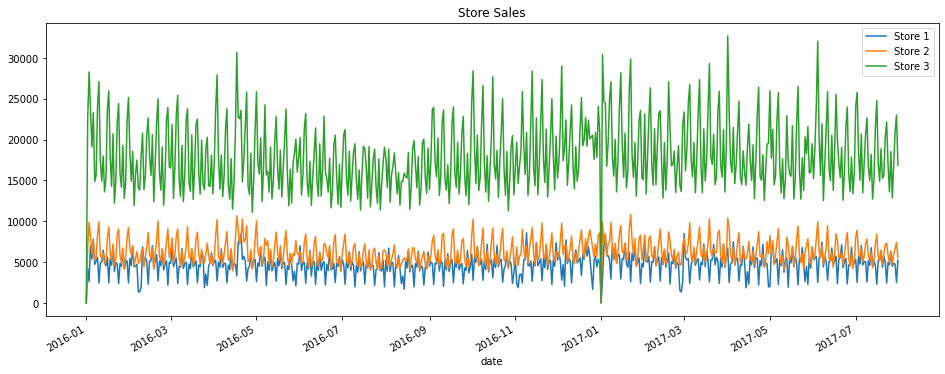

In [136]:
plt.figure(figsize=(16,6))
model_df['1'].plot(label='Store 1')
model_df['2'].plot(label='Store 2')
model_df['3'].plot(label='Store 3')
plt.title('Store Sales')
plt.legend();

## Store 1

Text(0.5, 1.0, 'Store 1')

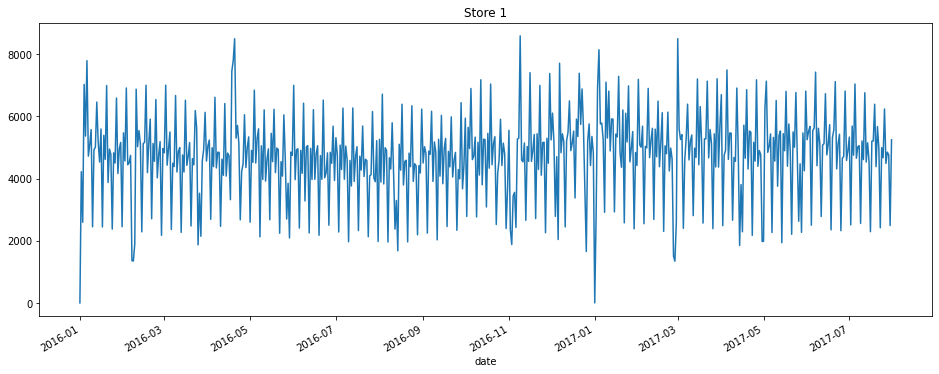

In [137]:
plt.figure(figsize=(16,6))
model_df['1'].plot()
plt.title('Store 1')

## Store 2

Text(0.5, 1.0, 'Store 2')

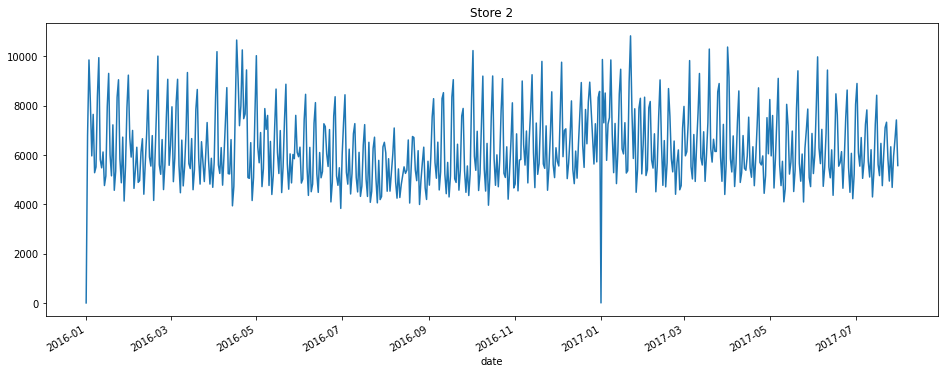

In [138]:
plt.figure(figsize=(16,6))
model_df['2'].plot()
plt.title('Store 2')

## Store 3

Text(0.5, 1.0, 'Store 3')

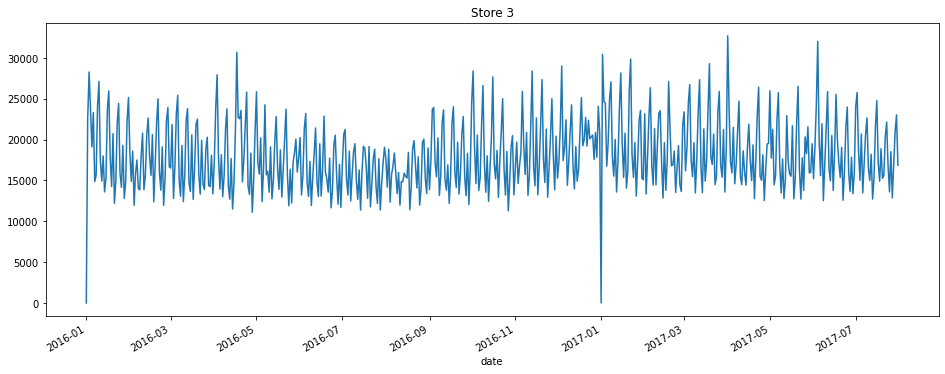

In [139]:
plt.figure(figsize=(16,6))
model_df['3'].plot()
plt.title('Store 3')

# Metrics

In [140]:
results = []

In [141]:
def score(actual_df, pred_df):
  frame = actual_df[pred_df.columns] - pred_df[pred_df.index >= SPLIT]
  error = frame.abs().mean(axis=0)
  return frame, error

In [142]:
def visualize(pred_df):
  fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(16,12), sharex=True)

  pred_df[pred_df.index >= '2017-01-01'].total.plot(label='Forecast', ax=ax[0])
  model_df[model_df.index >= '2017-01-01'].total.plot(label='Actual', ax=ax[0])
  ax[0].set_title('Total Sales')
  ax[0].legend()

  pred_df[pred_df.index >= '2017-01-01']['1'].plot(label='Forecast', ax=ax[1])
  model_df[model_df.index >= '2017-01-01']['1'].plot(label='Actual', ax=ax[1])
  ax[1].set_title('Store 1')
  ax[1].legend()

  pred_df[pred_df.index >= '2017-01-01']['2'].plot(label='Forecast', ax=ax[2])
  model_df[model_df.index >= '2017-01-01']['2'].plot(label='Actual', ax=ax[2])
  ax[2].set_title('Store 2')
  ax[2].legend()

  pred_df[pred_df.index >= '2017-01-01']['3'].plot(label='Forecast', ax=ax[3])
  model_df[model_df.index >= '2017-01-01']['3'].plot(label='Actual', ax=ax[3])
  ax[3].set_title('Store 3')
  ax[3].legend()

# Model

In [143]:
def decode(rm):
  if rm in REVISION_METHODS:
    return REVISION_METHODS[rm]
  return rm 

def fit_and_score(model, revision_method, model_df, hierarchy, fixup_pred=True):
  reg = HTSRegressor(model=model, revision_method=revision_method)
  reg = reg.fit(model_df, hierarchy, disable_progressbar=True)
  pred_df = reg.predict(steps_ahead=15, disable_progressbar=True)
  if fixup_pred:
    pred_df = fixup(pred_df)
  frame, error = score(actual_df, pred_df)
  result_df = pd.DataFrame(columns=pred_df.columns)
  result_df.loc[f'{decode(revision_method)} : {model}'] = error  
  return pred_df, result_df, error

def fit_models(revision_method, model_df, hierarchy, models=MODELS, fixup_pred=True):
  results = []
  for model in models:
    _, result_df, _ = fit_and_score(model, revision_method, model_df, hierarchy, fixup_pred=fixup_pred)
    results.append(result_df)
  return pd.concat(results)

def fixup(df):
  swap = df['1'].copy()
  df['1'] = df['3']
  df['3'] = swap 
  return df

## Single Level Hierarchy
![](https://otexts.com/fpp3/figs/hts.png)

## Grouped Structure
* Does not aggregate into a hierarchy
* https://otexts.com/fpp3/hts.html
![](https://otexts.com/fpp3/fpp_files/figure-html/GroupTree-1.png)

## Baseline

### Holt Winters

In [144]:
reg = HTSRegressor(model='holt_winters', revision_method='NONE')
reg = reg.fit(model_df, hierarchy)
pred_df = reg.predict(steps_ahead=15)

Fitting models: 100%|██████████| 5/5 [00:00<00:00, 41.96it/s]


In [178]:
reg.hts_result.models

{'1': HoltWintersModel(node=- 1
    |- 1_BEVERAGES
    |- 1_HOME CARE
    - 1_PRODUCE
 ), '1_BEVERAGES': HoltWintersModel(node=- 1_BEVERAGES
 ), '1_HOME CARE': HoltWintersModel(node=- 1_HOME CARE
 ), '1_PRODUCE': HoltWintersModel(node=- 1_PRODUCE
 ), '2': HoltWintersModel(node=- 2
    |- 2_BEVERAGES
    |- 2_HOME CARE
    - 2_PRODUCE
 ), '2_BEVERAGES': HoltWintersModel(node=- 2_BEVERAGES
 ), '2_HOME CARE': HoltWintersModel(node=- 2_HOME CARE
 ), '2_PRODUCE': HoltWintersModel(node=- 2_PRODUCE
 ), '3': HoltWintersModel(node=- 3
    |- 3_BEVERAGES
    |- 3_HOME CARE
    - 3_PRODUCE
 ), '3_BEVERAGES': HoltWintersModel(node=- 3_BEVERAGES
 ), '3_HOME CARE': HoltWintersModel(node=- 3_HOME CARE
 ), '3_PRODUCE': HoltWintersModel(node=- 3_PRODUCE
 ), 'total': HoltWintersModel(node=- total
    |- 1
    |  |- 1_BEVERAGES
    |  |- 1_HOME CARE
    |  - 1_PRODUCE
    |- 2
    |  |- 2_BEVERAGES
    |  |- 2_HOME CARE
    |  - 2_PRODUCE
    - 3
       |- 3_BEVERAGES
       |- 3_HOME CARE
       - 3_PRO

In [145]:
frame, error = score(actual_df, pred_df)
for field, field_err in zip(pred_df.columns, error):
  print(f'{field:>20}\t{field_err:.2f}')

               total	3984.48
                   1	1100.99
                   2	1090.86
                   3	2688.65
         1_BEVERAGES	440.08
         1_HOME CARE	47.61
           1_PRODUCE	694.00
         2_BEVERAGES	633.21
         2_HOME CARE	73.99
           2_PRODUCE	427.54
         3_BEVERAGES	1657.61
         3_HOME CARE	108.74
           3_PRODUCE	1259.69


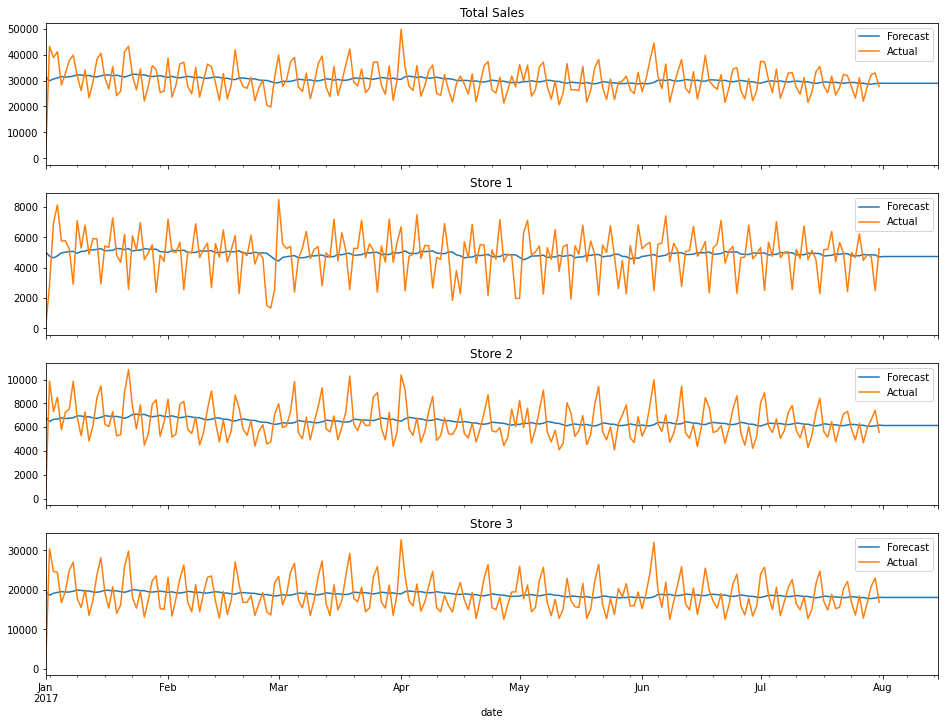

In [146]:
visualize(pred_df)

In [147]:
result_df = fit_models('NONE', model_df, hierarchy, fixup_pred=False)
results.append(result_df)
result_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,total,1,2,3,1_BEVERAGES,1_HOME CARE,1_PRODUCE,2_BEVERAGES,2_HOME CARE,2_PRODUCE,3_BEVERAGES,3_HOME CARE,3_PRODUCE
Baseline : prophet,3520.952538,708.748091,983.245216,2097.850608,343.958986,37.352092,346.115069,700.464560,61.673638,300.915275,1392.228542,94.378228,751.420109
Baseline : holt_winters,3984.478092,1100.985797,1090.855222,2688.652151,440.083833,47.606296,693.999204,633.206309,73.993775,427.535821,1657.606492,108.736534,1259.686889
Baseline : sarimax,5114.504594,1783.485293,1439.571649,4306.865998,691.134954,51.791100,1228.052036,672.988080,107.463610,957.124169,2368.415232,117.801814,2621.303527


### SARIMAX

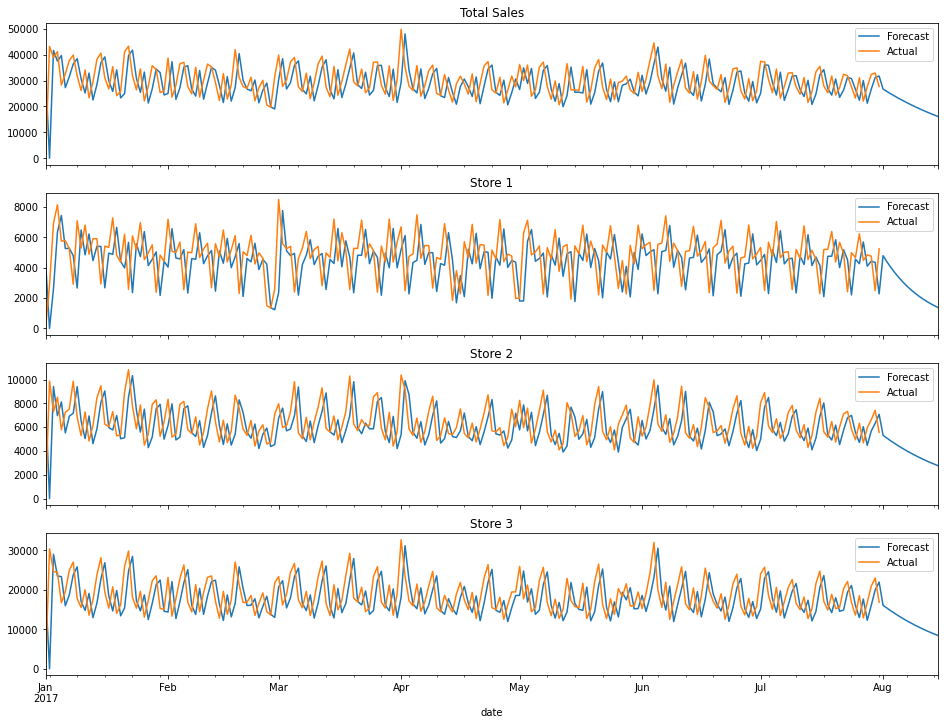

In [148]:
reg = HTSRegressor(model='sarimax', revision_method='NONE')
reg = reg.fit(model_df, hierarchy, disable_progressbar=True)
pred_df = reg.predict(steps_ahead=15, disable_progressbar=True)
visualize(pred_df)

### FBProphet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

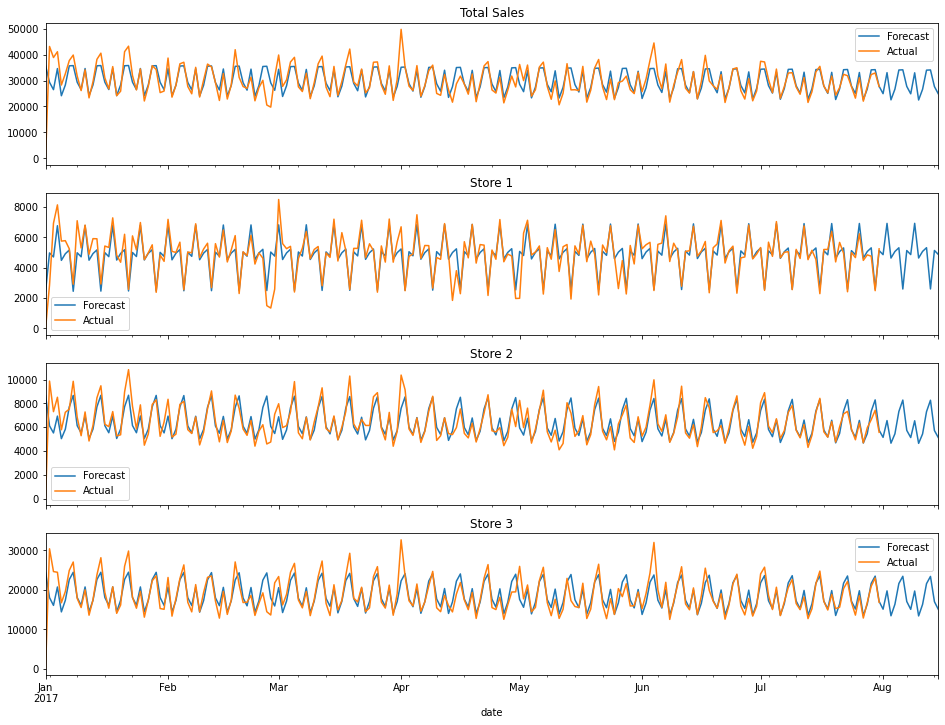

In [149]:
reg = HTSRegressor(model='prophet', revision_method='NONE')
reg = reg.fit(model_df, hierarchy, disable_progressbar=True)
pred_df = reg.predict(steps_ahead=15, disable_progressbar=True)
visualize(pred_df)

## Bottom-Up
* Very common approach
* Forecast at the lowest level in the hierarchy
* Aggregate across the levels
* Because we're aggregating "upwards", no information is lost

### Holt Winters

In [150]:
reg = HTSRegressor(model='holt_winters', revision_method='BU')
reg = reg.fit(model_df, hierarchy)
pred_df = reg.predict(steps_ahead=15)
pred_df = fixup(pred_df)

Fitting models: 100%|██████████| 5/5 [00:00<00:00, 51.08it/s]


In [151]:
frame, error = score(actual_df, pred_df)
for field, field_err in zip(pred_df.columns, error):
  print(f'{field:>20}\t{field_err:.2f}')

               total	4012.56
                   1	1105.67
                   2	1078.36
                   3	2685.33
         1_BEVERAGES	440.08
         1_HOME CARE	47.61
           1_PRODUCE	694.00
         2_BEVERAGES	633.21
         2_HOME CARE	73.99
           2_PRODUCE	427.54
         3_BEVERAGES	1657.61
         3_HOME CARE	108.74
           3_PRODUCE	1259.69


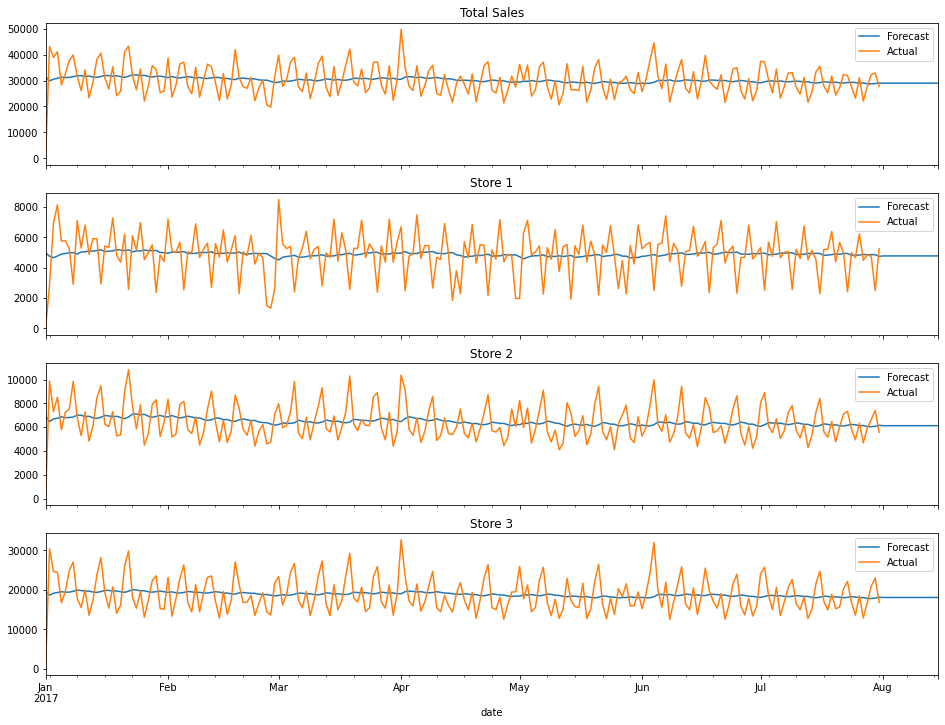

In [152]:
# Forecast vs Actual -- Bottom Up
visualize(pred_df)

In [153]:
result_df = fit_models('BU', model_df, hierarchy)
results.append(result_df)
result_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,total,1,2,3,1_BEVERAGES,1_HOME CARE,1_PRODUCE,2_BEVERAGES,2_HOME CARE,2_PRODUCE,3_BEVERAGES,3_HOME CARE,3_PRODUCE
Bottom Up : prophet,3661.528356,698.602990,994.788774,2121.768678,343.958986,37.352092,346.115069,700.464560,61.673638,300.915275,1392.228542,94.378228,751.420109
Bottom Up : holt_winters,4012.557372,1105.674414,1078.360942,2685.331994,440.083833,47.606296,693.999204,633.206309,73.993775,427.535821,1657.606492,108.736534,1259.686889
Bottom Up : sarimax,8541.314409,1956.804946,1711.304666,4994.107949,691.134954,51.791100,1228.052036,672.988080,107.463610,957.124169,2368.415232,117.801814,2621.303527


### SARIMAX

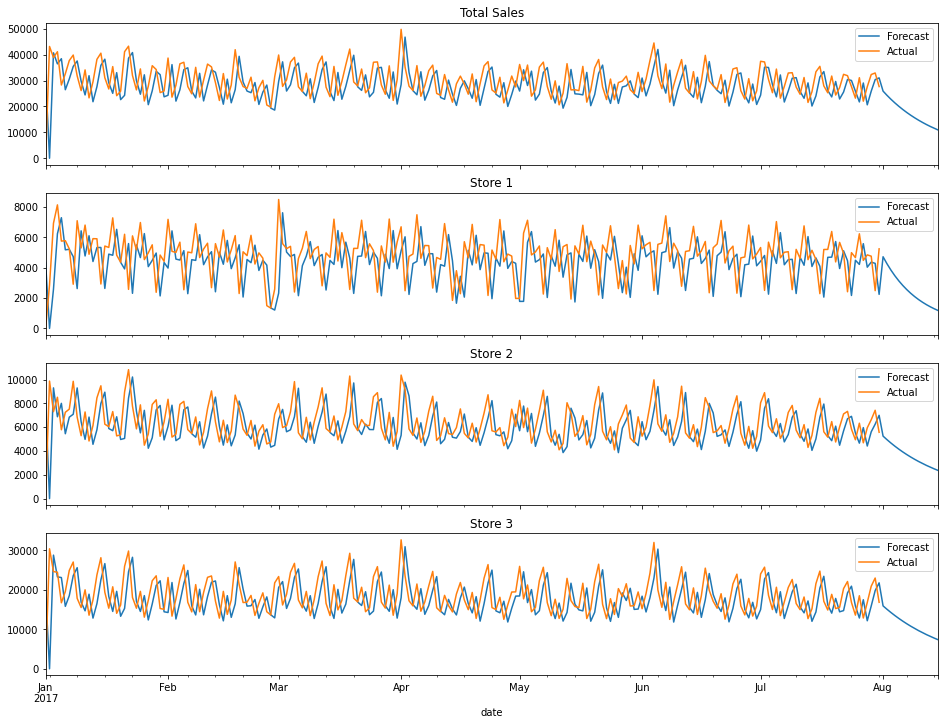

In [154]:
reg = HTSRegressor(model='sarimax', revision_method='BU')
reg = reg.fit(model_df, hierarchy, disable_progressbar=True)
pred_df = reg.predict(steps_ahead=15, disable_progressbar=True)
pred_df = fixup(pred_df)
visualize(pred_df)

### FBProphet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

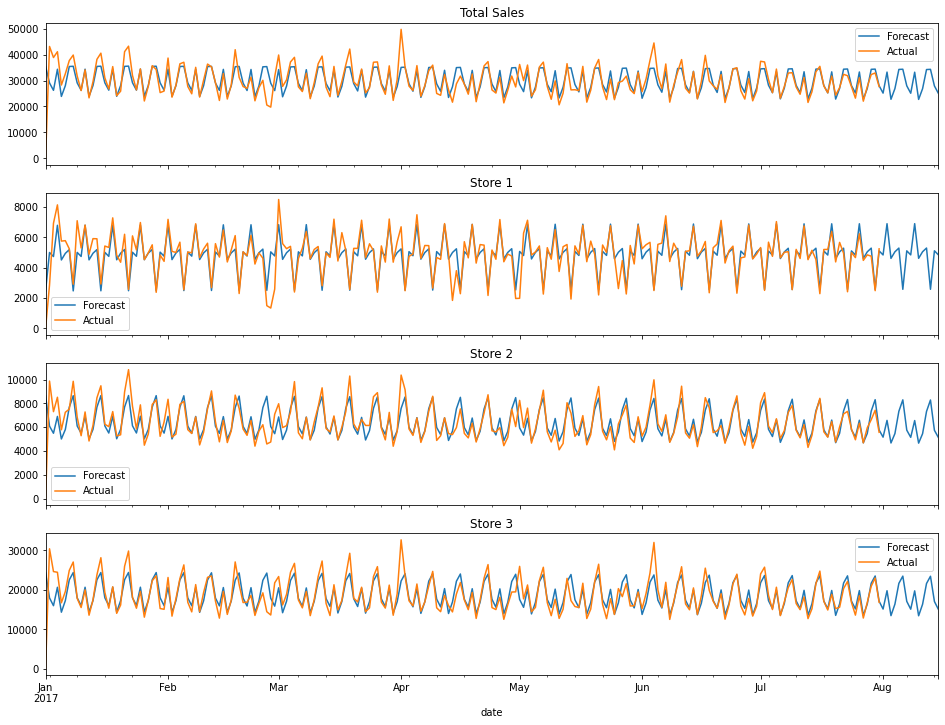

In [155]:
reg = HTSRegressor(model='prophet', revision_method='BU')
reg = reg.fit(model_df, hierarchy, disable_progressbar=True)
pred_df = reg.predict(steps_ahead=15, disable_progressbar=True)
pred_df = fixup(pred_df)
visualize(pred_df)

## Top Down
* Forecast at the highest level
* Cascade the forecast down based on proportions

### Holt Winters

In [156]:
reg = HTSRegressor(model='holt_winters', revision_method='PHA')
reg = reg.fit(model_df, hierarchy)
pred_df = reg.predict(steps_ahead=15)
pred_df = fixup(pred_df)

Fitting models: 100%|██████████| 5/5 [00:00<00:00, 51.02it/s]
/usr/local/lib/python3.7/dist-packages/hts/functions.py:175: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fcst = fcst[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/hts/hierarchy/__init__.py:361: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  [self.item] + [c.item[c.key] for c in self.traversal_level()], 1
/usr/local/lib/python3.7/dist-packages/hts/functions.py:191: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  props = props[:, np.newaxis]


In [157]:
frame, error = score(actual_df, pred_df)
for field, field_err in zip(pred_df.columns, error):
  print(f'{field:>20}\t{field_err:.2f}')

               total	3984.48
                   1	1098.36
                   2	1174.91
                   3	2625.43
         1_BEVERAGES	437.31
         1_HOME CARE	40.59
           1_PRODUCE	687.45
         2_BEVERAGES	558.48
         2_HOME CARE	68.83
           2_PRODUCE	572.84
         3_BEVERAGES	1438.21
         3_HOME CARE	93.67
           3_PRODUCE	1383.52


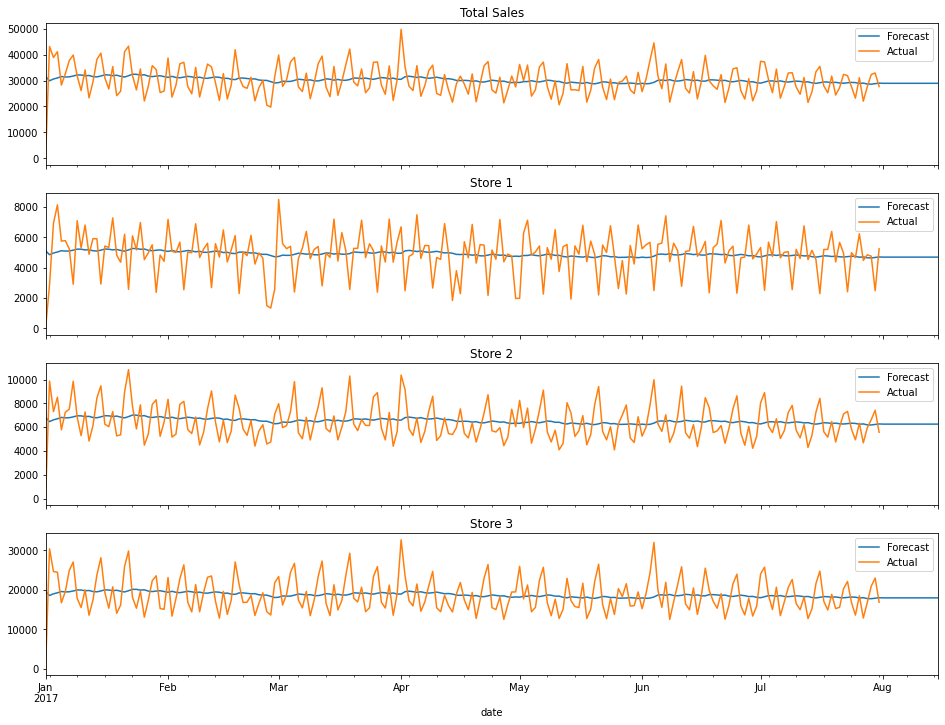

In [158]:
visualize(pred_df)

In [159]:
result_df = fit_models('PHA', model_df, hierarchy)
results.append(result_df)
result_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,total,1,2,3,1_BEVERAGES,1_HOME CARE,1_PRODUCE,2_BEVERAGES,2_HOME CARE,2_PRODUCE,3_BEVERAGES,3_HOME CARE,3_PRODUCE
Proportions : prophet,3520.952538,1401.587826,985.996710,1861.385201,610.906075,56.340912,748.227069,568.563211,61.699782,453.299558,1096.530518,67.168425,943.639450
Proportions : holt_winters,3984.478092,1098.364656,1174.909254,2625.431656,437.313512,40.590465,687.450991,558.481057,68.825124,572.837387,1438.209616,93.672234,1383.518089
Proportions : sarimax,5114.504594,1446.005993,896.606605,3290.796187,651.938907,52.325685,764.175982,465.526001,32.483301,463.486060,1470.095875,118.238158,1755.525995


### SARIMAX

/usr/local/lib/python3.7/dist-packages/hts/functions.py:175: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fcst = fcst[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/hts/hierarchy/__init__.py:361: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  [self.item] + [c.item[c.key] for c in self.traversal_level()], 1
/usr/local/lib/python3.7/dist-packages/hts/functions.py:191: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  props = props[:, np.newaxis]


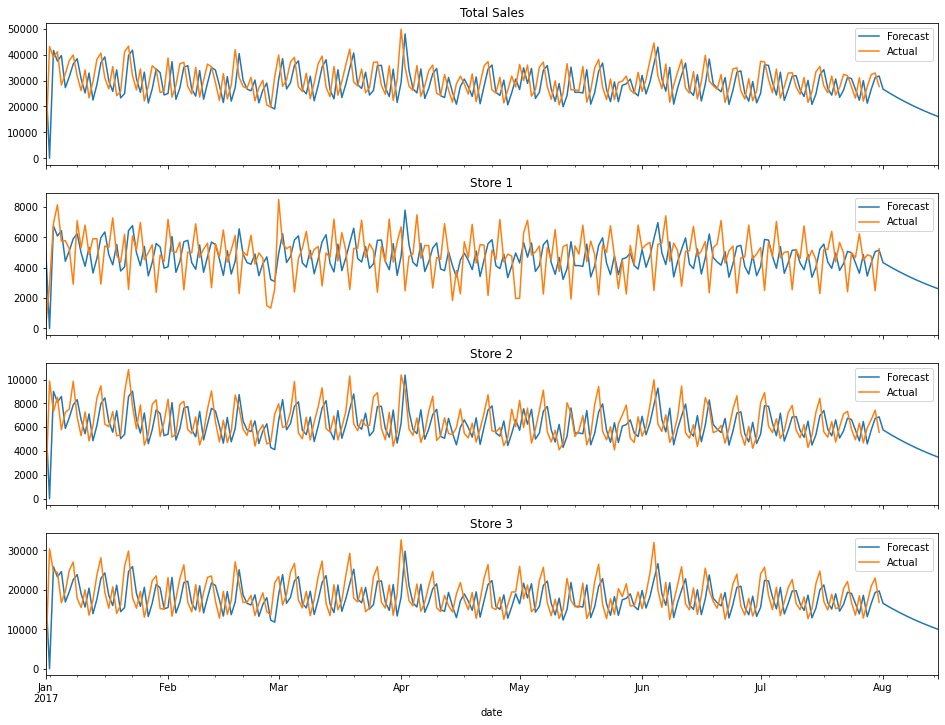

In [160]:
reg = HTSRegressor(model='sarimax', revision_method='PHA')
reg = reg.fit(model_df, hierarchy, disable_progressbar=True)
pred_df = reg.predict(steps_ahead=15, disable_progressbar=True)
pred_df = fixup(pred_df)
visualize(pred_df)

### FBProphet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

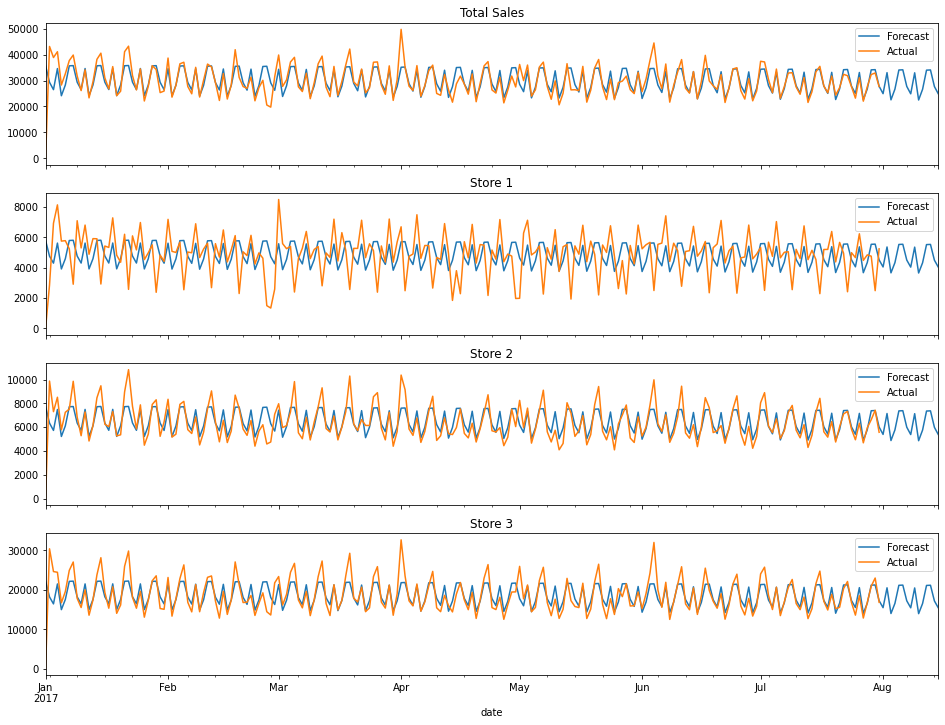

In [161]:
reg = HTSRegressor(model='prophet', revision_method='PHA')
reg = reg.fit(model_df, hierarchy, disable_progressbar=True)
pred_df = reg.predict(steps_ahead=15, disable_progressbar=True)
pred_df = fixup(pred_df)
visualize(pred_df)

## Middle - Out
* Useful for hierarchies at least 3 high
* Forecast a middle
  * Bottom up to the higher levels
  * Top down allocation to lower levels

## Optimal Combination
* Suggested by Hyndman in forecast package
* Forecast all levels
* Use a linear regression to reconcile the forecasts

### Holt Winters

In [162]:
reg = HTSRegressor(model='holt_winters', revision_method='OLS')
reg = reg.fit(model_df, hierarchy)
pred_df = reg.predict(steps_ahead=15)

Fitting models: 100%|██████████| 5/5 [00:00<00:00, 55.86it/s]


In [163]:
frame, error = score(actual_df, pred_df)
for field, field_err in zip(pred_df.columns, error):
  print(f'{field:>20}\t{field_err:.2f}')

               total	3990.80
                   1	3657.84
                   2	1081.94
                   3	2001.04
         1_BEVERAGES	3484.04
         1_HOME CARE	3346.70
           1_PRODUCE	3510.39
         2_BEVERAGES	634.40
         2_HOME CARE	74.99
           2_PRODUCE	428.51
         3_BEVERAGES	1991.48
         3_HOME CARE	3262.91
           3_PRODUCE	2786.24


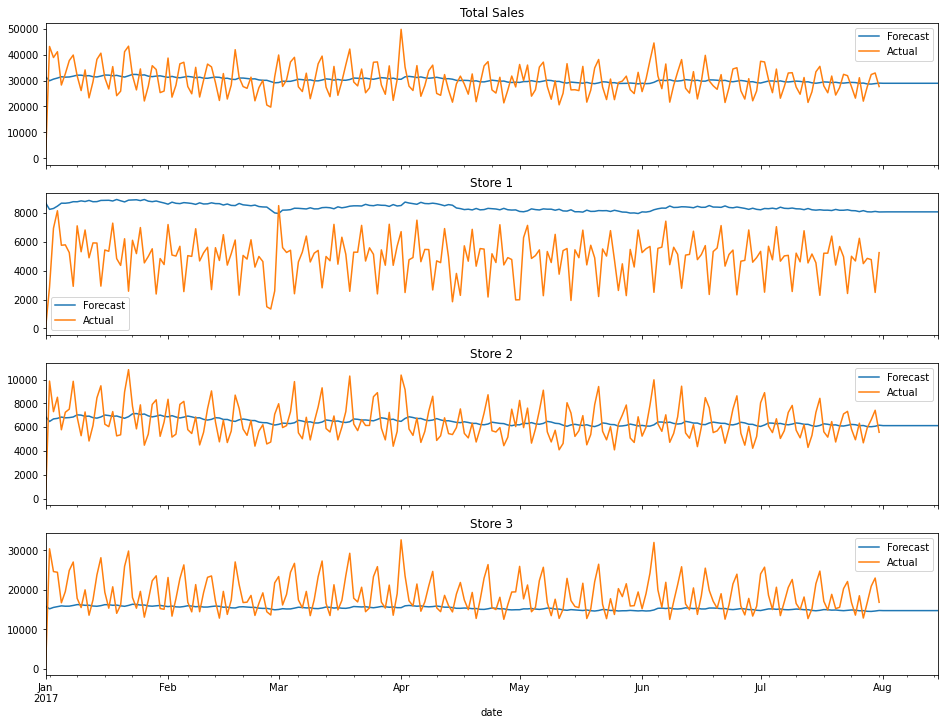

In [164]:
visualize(pred_df)

In [165]:
result_df = fit_models('OLS', model_df, hierarchy, fixup_pred=False)
results.append(result_df)
result_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,total,1,2,3,1_BEVERAGES,1_HOME CARE,1_PRODUCE,2_BEVERAGES,2_HOME CARE,2_PRODUCE,3_BEVERAGES,3_HOME CARE,3_PRODUCE
Optimal : prophet,3558.989754,3727.295313,957.986731,1928.124688,3457.246051,3250.375457,3484.229253,688.197212,46.748395,291.065304,1943.073413,3210.649735,2817.454979
Optimal : holt_winters,3990.800949,3657.842807,1081.935700,2001.044647,3484.037720,3346.701832,3510.394587,634.397896,74.991385,428.510755,1991.477106,3262.913732,2786.239796
Optimal : sarimax,5899.768094,1453.685981,929.188892,5939.187050,1933.665837,2493.977220,1408.137839,408.738951,177.934055,671.726504,4247.061231,1980.376086,4397.071712


### SARIMAX

In [166]:
reg = HTSRegressor(model='sarimax', revision_method='OLS')
reg = reg.fit(model_df, hierarchy)
pred_df = reg.predict(steps_ahead=15)
pred_df = fixup(pred_df)

Fitting models: 100%|██████████| 5/5 [00:00<00:00, 24.69it/s]


### FBProphet

In [167]:
reg = HTSRegressor(model='prophet', revision_method='OLS')
reg = reg.fit(model_df, hierarchy)
pred_df = reg.predict(steps_ahead=15)
pred_df = fixup(pred_df)

Fitting models:   0%|          | 0/5 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  20%|██        | 1/5 [00:01<00:05,  1.30s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with 

### Inspection

In [168]:
pred_df

,total,1,2,3,1_BEVERAGES,1_HOME CARE,1_PRODUCE,2_BEVERAGES,2_HOME CARE,2_PRODUCE,3_BEVERAGES,3_HOME CARE,3_PRODUCE
2016-01-01,27023.721306,13540.623577,5790.603034,7692.494695,5067.618786,3085.772778,5387.232013,2940.202262,276.556747,2573.844025,4941.925997,-2488.420011,5238.988709
2016-01-02,34410.190954,17553.933911,7664.047159,9192.209884,6447.180080,4361.094422,6745.659409,4004.613159,336.188327,3323.245673,6858.441610,-3529.199083,5862.967357
2016-01-03,34483.857830,18248.512593,8623.719891,7611.625346,6250.271061,5394.158131,6604.083402,4536.771376,382.026938,3704.921577,6919.082417,-4589.941554,5282.484483
2016-01-04,28067.427780,14078.386568,6076.931354,7912.109858,5211.864980,3266.972454,5599.549133,3036.751721,297.560380,2742.619253,5023.017518,-2588.082234,5477.174574
2016-01-05,25205.270141,12518.657956,5472.845392,7213.766793,4736.511706,2833.647829,4948.498421,2748.587728,259.503926,2464.753738,4594.046537,-2217.775942,4837.496197
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,26686.846871,13452.916303,5386.129853,7847.800714,5173.533672,2977.378223,5302.004408,3031.327333,239.898867,2114.903654,5665.450297,-2360.386524,4542.736941
2017-08-12,34076.696961,17467.987442,7260.034945,9348.674575,6553.244737,4252.959045,6661.783660,4096.087068,299.264768,2864.683109,7582.144416,-3401.694173,5168.224332
2017-08-13,34153.744281,18164.326930,8220.168643,7769.248708,6356.485488,5286.281933,6521.559509,4628.594122,344.837701,3246.736820,7642.963728,-4462.965221,4589.250201
2017-08-14,27740.694674,13995.961709,5673.841072,8070.891892,5318.229178,3159.355435,5518.377097,3128.923303,260.105466,2284.812304,5747.077335,-2461.634479,4785.449035


# Comparison

## Totals

In [169]:
results_df = pd.concat(results)
results_df[['total', '1', '2', '3']].sort_values('total')

,total,1,2,3
Baseline : prophet,3520.952538,708.748091,983.245216,2097.850608
Proportions : prophet,3520.952538,1401.587826,985.996710,1861.385201
Optimal : prophet,3558.989754,3727.295313,957.986731,1928.124688
Bottom Up : prophet,3661.528356,698.602990,994.788774,2121.768678
Baseline : holt_winters,3984.478092,1100.985797,1090.855222,2688.652151
Proportions : holt_winters,3984.478092,1098.364656,1174.909254,2625.431656
Optimal : holt_winters,3990.800949,3657.842807,1081.935700,2001.044647
Bottom Up : holt_winters,4012.557372,1105.674414,1078.360942,2685.331994
Baseline : sarimax,5114.504594,1783.485293,1439.571649,4306.865998
Proportions : sarimax,5114.504594,1446.005993,896.606605,3290.796187


## Store 1

In [170]:
cols = [c for c in results_df.columns if c.startswith('1')]
results_df[cols].sort_values('1')

,1,1_BEVERAGES,1_HOME CARE,1_PRODUCE
Bottom Up : prophet,698.602990,343.958986,37.352092,346.115069
Baseline : prophet,708.748091,343.958986,37.352092,346.115069
Proportions : holt_winters,1098.364656,437.313512,40.590465,687.450991
Baseline : holt_winters,1100.985797,440.083833,47.606296,693.999204
Bottom Up : holt_winters,1105.674414,440.083833,47.606296,693.999204
Proportions : prophet,1401.587826,610.906075,56.340912,748.227069
Proportions : sarimax,1446.005993,651.938907,52.325685,764.175982
Optimal : sarimax,1453.685981,1933.665837,2493.977220,1408.137839
Baseline : sarimax,1783.485293,691.134954,51.791100,1228.052036
Bottom Up : sarimax,1956.804946,691.134954,51.791100,1228.052036


## Beverages

In [171]:
INTEREST = 'BEVERAGES'
cols = [c for c in results_df.columns if c.endswith(INTEREST)]
drill_df = results_df[cols].copy()
drill_df[INTEREST] = drill_df.mean(axis=1)
drill_df.sort_values(INTEREST)

,1_BEVERAGES,2_BEVERAGES,3_BEVERAGES,BEVERAGES
Proportions : prophet,610.906075,568.563211,1096.530518,758.666601
Proportions : holt_winters,437.313512,558.481057,1438.209616,811.334729
Baseline : prophet,343.958986,700.464560,1392.228542,812.217362
Bottom Up : prophet,343.958986,700.464560,1392.228542,812.217362
Proportions : sarimax,651.938907,465.526001,1470.095875,862.520261
Baseline : holt_winters,440.083833,633.206309,1657.606492,910.298878
Bottom Up : holt_winters,440.083833,633.206309,1657.606492,910.298878
Baseline : sarimax,691.134954,672.988080,2368.415232,1244.179422
Bottom Up : sarimax,691.134954,672.988080,2368.415232,1244.179422
Optimal : prophet,3457.246051,688.197212,1943.073413,2029.505559


# Thoughts
* scikit-hts has good intentions
  * Seems either incorrect implementation or usage requiring fixup of columns
  * Rendered some of the strategies unusable
  * OLS model forecasted "returns" for 3_HOME_CARE
  * Auto-Arima implementations, extremely slow
* Consider R for stability & completeness
* Evaluation criteria considerations